In [7]:
# -*- coding: utf-8 -*-
import json
import os
import time

import matplotlib.pyplot as plt
from joblib import Parallel, delayed
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

from preprocessings.ja.stopwords import get_stop_words
DATA_DIR = os.path.join(os.getcwd(), 'data/processed')

In [8]:
from preprocessings.ja.cleaning import clean_text
from preprocessings.ja.normalization import normalize
from preprocessings.ja.tokenizer import MeCabTokenizer

tokenizer = MeCabTokenizer()
tokenizer_neologd = MeCabTokenizer('/usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
def with_preprocess(text):
    text = clean_text(text)
    words = tokenizer_neologd.wakati_baseform(text)
    words = [normalize(word) for word in words]
    return words


def no_preprocess(text):
    words = tokenizer.wakati_baseform(text)
    return words


def load_data(file_path):
    with open(file_path) as f:
        items = json.load(f)
        
    return items


def build_pipeline(stopwords):
    parameters = {'n_estimators': [10, 30, 50, 70, 90, 110, 130, 150], 'max_features': ['auto', 'sqrt', 'log2', None]}
    text_clf = Pipeline([('vect', CountVectorizer(stop_words=stopwords)),
                         ('tfidf', TfidfTransformer()),
                         ('clf', GridSearchCV(RandomForestClassifier(), parameters, cv=2, scoring='accuracy', n_jobs=-1)),
                         ])
    return text_clf

# No preprocessing

In [9]:
items = load_data(os.path.join(DATA_DIR, 'livedoor.json'))

start_time = time.time()  # for measuring running time 
items['data'] = Parallel(n_jobs=-1)([delayed(no_preprocess)(text) for text in items['data']])
items['data'] = [' '.join(doc) for doc in items['data']]
X_train, X_test, y_train, y_test = train_test_split(items['data'], items['label'], test_size=0.4)
text_clf = build_pipeline(stopwords=set())
text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
end_time = time.time()

# Evaluation
running_time1 = end_time - start_time
print('It took {} seconds.'.format(running_time1))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

It took 594.5124270915985 seconds.
Accuracy: 0.8982015609093994
             precision    recall  f1-score   support

          0       0.80      0.85      0.82       348
          1       0.94      0.93      0.93       335
          2       0.94      0.91      0.93       359
          3       0.98      0.53      0.69       197
          4       0.88      0.99      0.93       340
          5       0.79      0.81      0.80       338
          6       0.99      1.00      0.99       346
          7       0.88      0.99      0.93       348
          8       0.97      0.92      0.94       336

avg / total       0.90      0.90      0.90      2947



# With preprocessing

In [10]:
items = load_data(os.path.join(DATA_DIR, 'livedoor.json'))

start_time = time.time()  # for measuring running time
items['data'] = Parallel(n_jobs=-1)([delayed(with_preprocess)(text) for text in items['data']])
stopwords = get_stop_words(items['data'], n=100, min_freq=20)
items['data'] = [' '.join(doc) for doc in items['data']]
X_train, X_test, y_train, y_test = train_test_split(items['data'], items['label'], test_size=0.4)
text_clf = build_pipeline(stopwords=stopwords)
text_clf = text_clf.fit(X_train, y_train)
y_pred = text_clf.predict(X_test)
end_time = time.time()

# Evaluation
running_time2 = end_time - start_time
print('It took {} seconds.'.format(running_time2))
print('Accuracy: {}'.format(accuracy_score(y_test, y_pred)))
print(classification_report(y_test, y_pred))

70816/81989


It took 328.7750949859619 seconds.
Accuracy: 0.9165252799457075
             precision    recall  f1-score   support

          0       0.83      0.91      0.87       329
          1       0.95      0.96      0.96       342
          2       0.95      0.93      0.94       377
          3       0.98      0.59      0.73       181
          4       0.88      0.98      0.93       348
          5       0.83      0.81      0.82       334
          6       0.99      1.00      0.99       355
          7       0.93      0.98      0.95       360
          8       0.96      0.93      0.95       321

avg / total       0.92      0.92      0.91      2947



# Running time

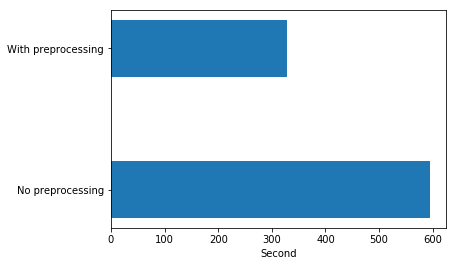

In [11]:
import matplotlib.pyplot as plt
plt.barh([0, 1], [running_time1, running_time2], height=0.4, align="center")
plt.yticks([0, 1], ["No preprocessing", "With preprocessing"])
plt.xlabel('Second')
plt.show()